In [58]:
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, accuracy, BaselineOnly
from surprise.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split

In [41]:
df_correspond = pd.read_csv('../df_correspond.csv', encoding= 'cp949') #21252 / 26421
df_correspond.columns = ['user_id', 'movie_id', 'rating']

In [42]:
traindata, testdata = train_test_split(df_correspond, test_size= 0.2, random_state= 42)

# Reader 객체 생성 (rating_scale은 평점의 최소값과 최대값을 지정)
reader = Reader(rating_scale=(1, 5))

# 데이터셋 생성
fullset = Dataset.load_from_df(df_correspond[['user_id', 'movie_id', 'rating']], reader)
trainset = Dataset.load_from_df(traindata[['user_id', 'movie_id', 'rating']], reader)
testset = Dataset.load_from_df(testdata[['user_id', 'movie_id', 'rating']], reader)

In [43]:
# 하이퍼파라미터 그리드 설정
param_grid = {'bsl_options': {'method': ['sgd', 'als'],
                              'reg': [0.05, 0.1], # 과적합 방지를 위한 값으로 클수록 더 강한 정규화
                              'learning_rate': [0.001, 0.01]}}

gs = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)
gs.fit(fullset)
print(gs.best_params['rmse'])

algo = gs.best_estimator['rmse']
trainset = trainset.build_full_trainset()
algo.fit(trainset)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
{'bsl_options': {'method': 'sgd', 'reg': 0.05, 'learning_rate': 0.01}}
Estimating biases using sgd...


In [ ]:
testset = testset.build_full_trainset()
testset = testset.build_testset()
predictions = algo.test(testset)

In [56]:
accuracy.rmse(predictions)

RMSE: 1.1445


1.144454907876286

In [54]:
# 예측 결과 출력
# for uid, iid, true_r, est, _ in predictions[:10]:
#     print(f"User {uid} -> Item {iid}: {true_r} -> {est:.2f}")

predictions_df = pd.DataFrame(predictions, columns=['user_id', 'movie_id', 'r_ui', 'est', 'details'])
predictions_df = predictions_df[['user_id', 'movie_id', 'r_ui', 'est']]

predictions_df['err'] = predictions_df['r_ui'] - predictions_df['est']
predictions_df


,user_id,movie_id,r_ui,est,err
0,5138,191,2.0,3.773635,-1.773635
1,630,46,5.0,4.775876,0.224124
2,7032,234,4.0,4.404474,-0.404474
3,4669,181,1.0,1.857353,-0.857353
4,8465,308,1.0,2.875510,-1.875510
...,...,...,...,...,...
4246,8181,263,5.0,4.563810,0.436190
4247,5897,207,5.0,3.612555,1.387445
4248,2123,131,5.0,4.647033,0.352967
4249,6835,230,5.0,4.881001,0.118999


In [60]:
cross_validate(algo, fullset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1663  1.1606  1.1413  1.1379  1.1606  1.1533  0.0115  
MAE (testset)     0.8438  0.8312  0.8255  0.8232  0.8288  0.8305  0.0072  
Fit time          0.06    0.05    0.05    0.03    0.04    0.05    0.01    
Test time         0.01    0.02    0.01    0.02    0.01    0.01    0.01    


{'test_rmse': array([1.16630878, 1.16062076, 1.14127301, 1.13785836, 1.16056849]),
 'test_mae': array([0.84382296, 0.83121152, 0.82552067, 0.82316695, 0.82876908]),
 'fit_time': (0.06001853942871094,
  0.04621267318725586,
  0.05458331108093262,
  0.0328371524810791,
  0.037932634353637695),
 'test_time': (0.009867191314697266,
  0.02207016944885254,
  0.014204263687133789,
  0.018918991088867188,
  0.007998466491699219)}

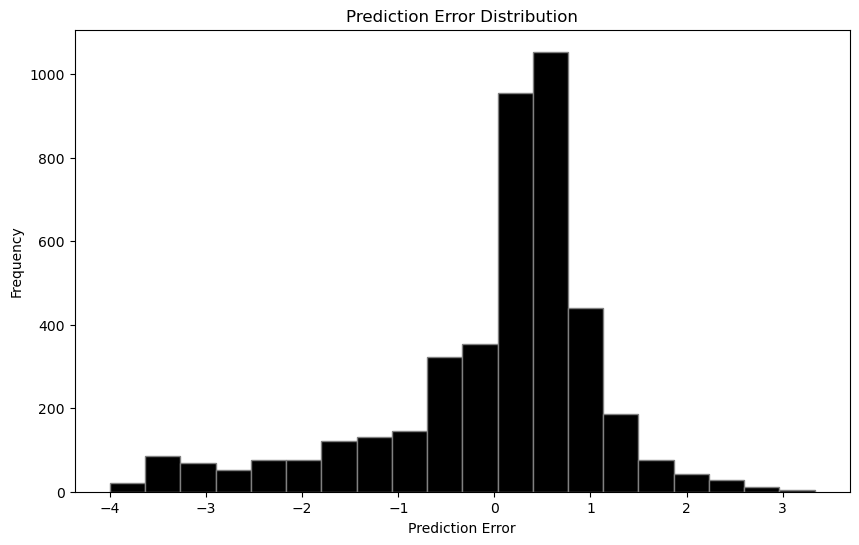

In [63]:
import matplotlib.pyplot as plt

# # 예측값과 실제값의 산포도 시각화
# plt.figure(figsize=(10, 6))
# plt.scatter(predictions_df['r_ui'], predictions_df['est'], alpha=0.5)
# plt.plot([1, 5], [1, 5], color='red', linestyle='--')
# plt.xlabel('Actual Rating')
# plt.ylabel('Predicted Rating')
# plt.title('Actual vs Predicted Ratings')
# plt.show()

# 오차 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(predictions_df['err'], bins=20, edgecolor='gray', color= 'black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

In [45]:
def get_top_n_recommendations(algo, user_movie_rating_df, user_id, n=20):
    # 모든 영화 목록
    all_movie_ids = user_movie_rating_df['movie_id'].unique()
    
    # 사용자가 이미 본 영화 목록
    seen_movie_ids = user_movie_rating_df[user_movie_rating_df['user_id'] == user_id]['movie_id'].unique()
    
    # 사용자가 보지 않은 영화 목록
    unseen_movie_ids = [movie_id for movie_id in all_movie_ids if movie_id not in seen_movie_ids]
    
    # 사용자가 보지 않은 영화들에 대한 예측 평점 계산
    predictions = [algo.predict(user_id, movie_id) for movie_id in unseen_movie_ids]
    
    # 예측 평점이 높은 순으로 정렬하여 상위 n개 영화 추천
    top_n_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # 추천 영화 ID 리스트 추출
    top_n_movie_ids = [pred.iid for pred in top_n_predictions]

    return top_n_movie_ids

In [46]:
# 사용자에게 영화 추천하기
user_id = 5138  # 추천을 받을 사용자의 ID
num_recommendations = 20  # 추천할 영화의 수
recommended_movie_ids = get_top_n_recommendations(algo, df_correspond, user_id, num_recommendations)
print("사용자에게 추천할 영화 ID 리스트:", recommended_movie_ids)

사용자에게 추천할 영화 ID 리스트: [162, 48, 61, 59, 16, 230, 203, 19, 71, 50, 36, 113, 35, 34, 98, 86, 168, 81, 23, 42]


SVD

In [64]:
from surprise import SVD

In [69]:
param_grid = {'n_factors': [75, 80, 85], 'lr_all': [0.01, 0.005, 0.003], 'reg_all': [0.07, 0.05, 0.04]} 
gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid) 
gs.fit(fullset) 

print('Best Score :', gs.best_score['rmse']) 
print('Best Parameters :', gs.best_params['rmse']) 


Best Score : 1.1547685328332817
Best Parameters : {'n_factors': 75, 'lr_all': 0.005, 'reg_all': 0.05}


In [71]:
algo_svm = gs.best_estimator['rmse']
algo_svm.fit(trainset)

In [73]:
# testset = testset.build_full_trainset()
# testset = testset.build_testset()
predictions_svm = algo_svm.test(testset)

In [74]:
accuracy.rmse(predictions_svm)

RMSE: 1.1483


1.1482707164235222

In [75]:
# 예측 결과 출력
# for uid, iid, true_r, est, _ in predictions[:10]:
#     print(f"User {uid} -> Item {iid}: {true_r} -> {est:.2f}")

predictions_svm_df = pd.DataFrame(predictions_svm, columns=['user_id', 'movie_id', 'r_ui', 'est', 'details'])
predictions_svm_df = predictions_df[['user_id', 'movie_id', 'r_ui', 'est']]

predictions_svm_df['err'] = predictions_svm_df['r_ui'] - predictions_svm_df['est']
predictions_svm_df


,user_id,movie_id,r_ui,est,err
0,5138,191,2.0,3.773635,-1.773635
1,630,46,5.0,4.775876,0.224124
2,7032,234,4.0,4.404474,-0.404474
3,4669,181,1.0,1.857353,-0.857353
4,8465,308,1.0,2.875510,-1.875510
...,...,...,...,...,...
4246,8181,263,5.0,4.563810,0.436190
4247,5897,207,5.0,3.612555,1.387445
4248,2123,131,5.0,4.647033,0.352967
4249,6835,230,5.0,4.881001,0.118999


In [76]:
cross_validate(algo, fullset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Estimating biases using sgd...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1694  1.1504  1.1421  1.1527  1.1525  1.1534  0.0089  
MAE (testset)     0.8374  0.8277  0.8275  0.8328  0.8323  0.8315  0.0037  
Fit time          0.06    0.05    0.05    0.06    0.05    0.06    0.01    
Test time         0.00    0.01    0.00    0.01    0.02    0.01    0.01    


{'test_rmse': array([1.16937682, 1.1503886 , 1.14210851, 1.15270456, 1.15254226]),
 'test_mae': array([0.83742089, 0.82766448, 0.82746224, 0.83284535, 0.83233751]),
 'fit_time': (0.06195664405822754,
  0.05120658874511719,
  0.04989361763000488,
  0.06417512893676758,
  0.049897193908691406),
 'test_time': (0.003735065460205078,
  0.014258861541748047,
  0.0,
  0.005721569061279297,
  0.01577472686767578)}

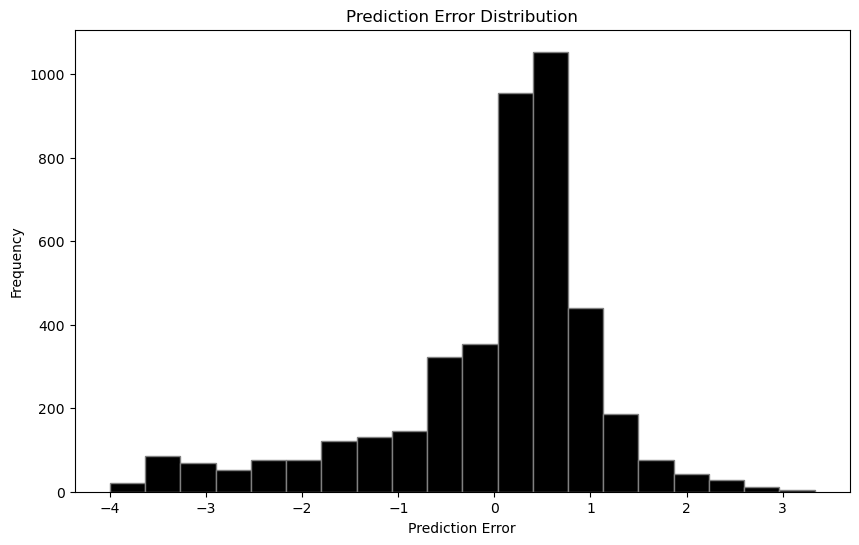

In [77]:
# 오차 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(predictions_svm_df['err'], bins=20, edgecolor='gray', color= 'black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

In [78]:
# 사용자에게 영화 추천하기
user_id = 5138  # 추천을 받을 사용자의 ID
num_recommendations = 20  # 추천할 영화의 수
recommended_movie_ids = get_top_n_recommendations(algo, df_correspond, user_id, num_recommendations)
print("사용자에게 추천할 영화 ID 리스트:", recommended_movie_ids)

사용자에게 추천할 영화 ID 리스트: [16, 61, 162, 48, 203, 264, 35, 36, 34, 113, 230, 409, 71, 139, 59, 86, 46, 50, 289, 410]
